In [ ]:
from fastai import *
from fastai.tabular import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Change this path for your project
path = "/content/drive/My Drive/FastAI/DoH-Exfiltration-Detection/data/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Feature Engineering - time series and filtering

In [ ]:
df = pd.read_csv(path + 'train.csv')

In [ ]:
df.columns

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'From_Target', 'OS', 'Software', 'Comm_Type', 'Session',
       'Info_Filtered', 'Handshake', 'Seq', 'Ack', 'Win', 'Len',
       'Conversation_dT', 'Conversation_Protocol_T-1',
       'Conversation_Protocol_T-2', 'Conversation_Protocol_T-3',
       'Conversation_Protocol_T-4', 'Conversation_Protocol_T-5',
       'Conversation_Protocol_T-6', 'Conversation_Protocol_T-7',
       'Conversation_Protocol_T-8', 'Conversation_Protocol_T-9',
       'Conversation_Length_T-1', 'Conversation_Length_T-2',
       'Conversation_Length_T-3', 'Conversation_Length_T-4',
       'Conversation_Length_T-5', 'Conversation_Length_T-6',
       'Conversation_Length_T-7', 'Conversation_Length_T-8',
       'Conversation_Length_T-9', 'Conversation_From_Target_T-1',
       'Conversation_From_Target_T-2', 'Conversation_From_Target_T-3',
       'Conversation_From_Target_T-4', 'Conversation_From_Target_T-5',
       'Conversation_From_T

In [ ]:
cat_vars = ['Protocol', 'From_Target', 'Handshake', 'Info_Filtered',
            'Conversation_Protocol_T-1','Conversation_Protocol_T-2','Conversation_Protocol_T-3','Conversation_Protocol_T-4','Conversation_Protocol_T-5',
            'Conversation_Protocol_T-6','Conversation_Protocol_T-7','Conversation_Protocol_T-8','Conversation_Protocol_T-9',
            'Conversation_From_Target_T-1','Conversation_From_Target_T-2','Conversation_From_Target_T-3','Conversation_From_Target_T-4','Conversation_From_Target_T-5',
            'Conversation_From_Target_T-6','Conversation_From_Target_T-7','Conversation_From_Target_T-8','Conversation_From_Target_T-9']

cont_vars = ['Length', 'Seq', 'Ack', 'Win', 'Len', 'Conversation_dT',
             'Conversation_Length_T-1', 'Conversation_Length_T-2', 'Conversation_Length_T-3', 'Conversation_Length_T-4', 'Conversation_Length_T-5',
             'Conversation_Length_T-6', 'Conversation_Length_T-7', 'Conversation_Length_T-8', 'Conversation_Length_T-9',
             'Conversation_dT_T-1', 'Conversation_dT_T-2', 'Conversation_dT_T-3', 'Conversation_dT_T-4', 'Conversation_dT_T-5',
             'Conversation_dT_T-6', 'Conversation_dT_T-7', 'Conversation_dT_T-8', 'Conversation_dT_T-9']

dep_var = 'Comm_Type'

procs=[FillMissing, Categorify, Normalize]

In [ ]:
df[3:6]

,No.,Time,Source,Destination,Protocol,Length,Info,From_Target,OS,Software,Comm_Type,Session,Info_Filtered,Handshake,Seq,Ack,Win,Len,Conversation_dT,Conversation_Protocol_T-1,Conversation_Protocol_T-2,Conversation_Protocol_T-3,Conversation_Protocol_T-4,Conversation_Protocol_T-5,Conversation_Protocol_T-6,Conversation_Protocol_T-7,Conversation_Protocol_T-8,Conversation_Protocol_T-9,Conversation_Length_T-1,Conversation_Length_T-2,Conversation_Length_T-3,Conversation_Length_T-4,Conversation_Length_T-5,Conversation_Length_T-6,Conversation_Length_T-7,Conversation_Length_T-8,Conversation_Length_T-9,Conversation_From_Target_T-1,Conversation_From_Target_T-2,Conversation_From_Target_T-3,Conversation_From_Target_T-4,Conversation_From_Target_T-5,Conversation_From_Target_T-6,Conversation_From_Target_T-7,Conversation_From_Target_T-8,Conversation_From_Target_T-9,Conversation_dT_T-1,Conversation_dT_T-2,Conversation_dT_T-3,Conversation_dT_T-4,Conversation_dT_T-5,Conversation_dT_T-6,Conversation_dT_T-7,Conversation_dT_T-8,Conversation_dT_T-9
3,5,1.035037,Target,1.1.1.1,TLSv1.2,213,Application Data,True,Windows 10,Chrome,DoH,1,Application Data,NaN,NaN,NaN,NaN,NaN,0.000063,TLSv1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,1.035572,Target,1.1.1.1,TLSv1.2,114,Application Data,True,Windows 10,Chrome,DoH,1,Application Data,NaN,NaN,NaN,NaN,NaN,0.000535,TLSv1.2,TLSv1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,1.035649,Target,1.1.1.1,TLSv1.2,114,Application Data,True,Windows 10,Chrome,DoH,1,Application Data,NaN,NaN,NaN,NaN,NaN,0.000077,TLSv1.2,TLSv1.2,TLSv1.2,NaN,NaN,NaN,NaN,NaN,NaN,114.0,213.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,0.000535,0.000063,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
np.unique(df['Comm_Type'])

array(['Browsing', 'DNS', 'DoH', 'Exfiltration'], dtype=object)

In [ ]:
np.random.seed(42)
data = (TabularList.from_df(df, cat_names=cat_vars, cont_names = cont_vars, procs=procs)
       .split_by_rand_pct(0.2)
       .label_from_df(cols=dep_var)
       #.add_test(TabularList.from_df(df_test, cat_names=cat_vars, cont_names=cont_vars))
       .databunch(bs=500))

In [ ]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001, 0.01], emb_drop = 0.04, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


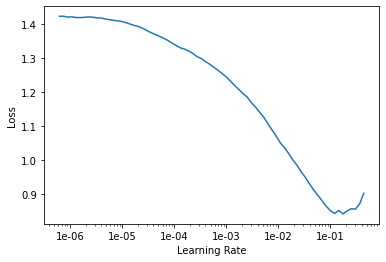

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr = 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.292237,0.130620,0.947257,00:14
1,0.150335,0.121396,0.951392,00:14
2,0.093238,0.075987,0.970780,00:14
3,0.062861,0.059292,0.978682,00:13
4,0.041318,0.053060,0.980520,00:14


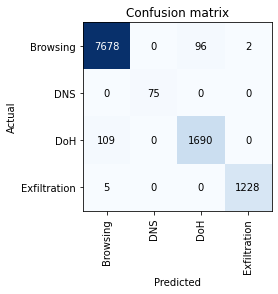

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_tab_top_losses(k=10)

,Prediction,Actual,Loss,Probability,Protocol,From_Target,Handshake,Info_Filtered,Conversation_Protocol_T-1,Conversation_Protocol_T-2,Conversation_Protocol_T-3,Conversation_Protocol_T-4,Conversation_Protocol_T-5,Conversation_Protocol_T-6,Conversation_Protocol_T-7,Conversation_Protocol_T-8,Conversation_Protocol_T-9,Conversation_From_Target_T-1,Conversation_From_Target_T-2,Conversation_From_Target_T-3,Conversation_From_Target_T-4,Conversation_From_Target_T-5,Conversation_From_Target_T-6,Conversation_From_Target_T-7,Conversation_From_Target_T-8,Conversation_From_Target_T-9,Seq_na,Ack_na,Win_na,Len_na,Conversation_dT_na,Conversation_Length_T-1_na,Conversation_Length_T-2_na,Conversation_Length_T-3_na,Conversation_Length_T-4_na,Conversation_Length_T-5_na,Conversation_Length_T-6_na,Conversation_Length_T-7_na,Conversation_Length_T-8_na,Conversation_Length_T-9_na,Conversation_dT_T-1_na,Conversation_dT_T-2_na,Conversation_dT_T-3_na,Conversation_dT_T-4_na,Conversation_dT_T-5_na,Conversation_dT_T-6_na,Conversation_dT_T-7_na,Conversation_dT_T-8_na,Conversation_dT_T-9_na,Length,Seq,Ack,Win,Len,Conversation_dT,Conversation_Length_T-1,Conversation_Length_T-2,Conversation_Length_T-3,Conversation_Length_T-4,Conversation_Length_T-5,Conversation_Length_T-6,Conversation_Length_T-7,Conversation_Length_T-8,Conversation_Length_T-9,Conversation_dT_T-1,Conversation_dT_T-2,Conversation_dT_T-3,Conversation_dT_T-4,Conversation_dT_T-5,Conversation_dT_T-6,Conversation_dT_T-7,Conversation_dT_T-8,Conversation_dT_T-9
0,Browsing,DoH,8.45,0.00,TCP,True,[ACK],Len=,TCP,TCP,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,True,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,-0.7347,-0.2261,-0.1999,0.0156,-0.3844,-0.1236,-0.7116,-0.7144,-0.6678,-0.6653,-0.6642,-0.6649,-0.6650,-0.6609,-0.6619,-0.1252,-0.1220,-0.1201,-0.1184,-0.1141,-0.1109,-0.1087,-0.1033,-0.1048
1,Browsing,DoH,8.14,0.00,TCP,False,ACK],WS=,TCP,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,True,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,-0.7145,-0.2261,-0.1999,-0.0996,-0.3844,-0.1233,-0.7116,-0.6705,-0.6678,-0.6653,-0.6642,-0.6649,-0.6650,-0.6609,-0.6619,-0.1255,-0.1220,-0.1201,-0.1184,-0.1141,-0.1109,-0.1087,-0.1033,-0.1048
2,Browsing,DoH,7.84,0.00,TCP,False,[ACK],Len=,TLSv1.2,TCP,TCP,TCP,#na#,#na#,#na#,#na#,#na#,True,True,False,True,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,True,True,True,True,True,True,-0.7347,-0.2261,-0.1971,-0.0986,-0.3844,-0.1234,0.1416,-0.7347,-0.7118,-0.7110,-0.6642,-0.6649,-0.6650,-0.6609,-0.6619,-0.1251,-0.1220,-0.1198,-0.1184,-0.1141,-0.1109,-0.1087,-0.1033,-0.1048
3,Browsing,DoH,7.62,0.00,TLSv1.3,False,#na#,Data,TLSv1.3,TLSv1.3,TCP,TLSv1.3,TLSv1.3,TLSv1.3,TLSv1.3,TCP,TLSv1.3,True,False,False,True,True,True,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.1461,-0.2195,-0.1927,-0.0504,-0.3844,-0.1234,-0.6795,0.1715,-0.7220,-0.4621,-0.5186,-0.5853,-0.6227,-0.7270,0.6591,-0.1255,-0.1220,-0.1131,-0.1184,-0.1141,-0.1109,-0.1077,-0.1033,-0.1048
4,Browsing,Exfiltration,7.28,0.00,TLSv1.3,False,#na#,Spec,TCP,TLSv1.3,TCP,TCP,TCP,#na#,#na#,#na#,#na#,False,True,True,False,True,#na#,#na#,#na#,#na#,True,True,True,True,False,False,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True,True,True,1.7279,-0.2195,-0.1927,-0.0504,-0.3844,-0.1193,-0.7217,0.1378,-0.7321,-0.7212,-0.6964,-0.6649,-0.6650,-0.6609,-0.6619,-0.1255,-0.1220,-0.1201,-0.1141,-0.1141,-0.1109,-0.1087,-0.1033,-0.1048
5,Browsing,Exfiltration,7.28,0.00,TLSv1.3,False,#na#,Spec,TCP,TLSv1.3,TCP,TCP,TCP,#na#,#na#,#na#,#na#,False,True,True,False,True,#na#,#na#,#na#,#na#,True,True,True,True,False,False,False,False,F

# Feature Importance

In [ ]:
# Thanks Zach Mueller!

def feature_importance(learn:Learner, dep_var:str, test:DataFrame):
  pd.options.mode.chained_assignment= None # Gets rid of annoying warning
  
  data = learn.data
  cats = [x for x in data.cat_names if '_na' not in x]
  conts = data.cont_names
  procs = data.procs
  
  dt = (TabularList.from_df(test, path='', cat_names=cats.copy(), cont_names=conts.copy(),
                           procs=procs)
       .split_none()
       .label_from_df(cols=dep_var))
  dt.valid = dt.train
  dt = dt.databunch()
  
  learn.data.valid_dl = dt.valid_dl
  loss0 = float(learn.validate()[1])
  
  types = [cats, conts]
  
  fi = dict()
  for j, t in enumerate(types):
    for i, c in enumerate(t):
      #print(c)
      base = test.copy()
      base[c] = base[c].sample(n=len(base), replace=True).reset_index(drop=True)
      
      
      dt = (TabularList.from_df(base, path='', cat_names=cats.copy(), cont_names=conts.copy(),
                         procs=procs)
       .split_none()
       .label_from_df(cols=dep_var))
      dt.valid = dt.train
      dt = dt.databunch()
      
      learn.data.valid_dl = dt.valid_dl
      fi[c] = float(learn.validate()[1]) - loss0
  
  d = sorted(fi.items(), key=lambda kv: kv[1])
  df = pd.DataFrame({'Variable': [l for l, v in d], u'Δ Accuracy': [v for l, v in d]})
  df['Type'] = ''
  for x in range(len(df)):
    if df['Variable'].iloc[x] in cats:
      df['Type'].iloc[x] = 'categorical'
    else:
      df['Type'].iloc[x] = 'continuous'
  return df

In [ ]:
df_unknown = pd.read_csv(path + 'feature-engineered/' + 'unknown-1-FE.csv')

In [ ]:
feature_importance(learn, dep_var, df_unknown)

,Variable,Δ Accuracy,Type
0,Conversation_Protocol_T-2,-0.014991,categorical
1,Conversation_Protocol_T-1,-0.012633,categorical
2,Conversation_Length_T-5,-0.010780,continuous
3,Conversation_Protocol_T-7,-0.008590,categorical
4,Conversation_Length_T-9,-0.007580,continuous
5,Conversation_Protocol_T-4,-0.007243,categorical
6,Conversation_Protocol_T-5,-0.007243,categorical
7,Conversation_Protocol_T-3,-0.006232,categorical
8,Conversation_Length_T-6,-0.005053,continuous
9,Handshake,-0.004548,categorical


# Test on DoH data

I recorded some data using Firefox's default DoH mechanism as well, but I couldn't find cloudflare's 1.1.1.1 in the data, so I used the model to find the address for me.

In [ ]:
data_unknown = (TabularList.from_df(df_unknown, cat_names=cat_vars, cont_names=cont_vars, procs=procs, processor=learn.data.processor)
                           .split_none()
                           .label_from_df(cols=dep_var))
data_unknown.valid = data_unknown.train
data_unknown=data_unknown.databunch()
learn.data.valid_dl = data_unknown.valid_dl

In [ ]:
learn.validate()

[0.061186742, tensor(0.9756)]

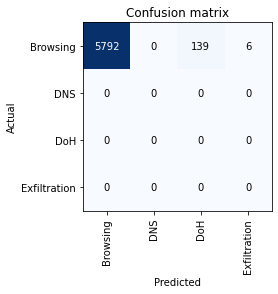

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
data_unknown = (TabularList.from_df(df_unknown, cat_names=cat_vars, cont_names=cont_vars, procs=procs, processor=learn.data.processor)
                           .split_none()
                           .label_from_df(cols=dep_var)).databunch()

In [ ]:
len(df_unknown)

5937

In [ ]:
preds = learn.get_preds(DatasetType.Valid)
preds

[tensor([[9.9843e-01, 1.5682e-05, 3.2049e-04, 1.2314e-03],
         [9.1312e-01, 2.0746e-04, 3.5578e-05, 8.6642e-02],
         [9.7407e-01, 8.5657e-05, 1.9060e-04, 2.5650e-02],
         ...,
         [9.9990e-01, 4.7402e-07, 9.0590e-05, 6.0398e-06],
         [6.0363e-01, 4.2657e-06, 3.9636e-01, 3.5994e-06],
         [7.4858e-01, 3.5995e-05, 2.5132e-01, 6.3533e-05]]),
 tensor([0, 0, 0,  ..., 0, 0, 0])]

In [ ]:
type = 'DoH'
col = 2
t = []
for i in range(len(df_unknown)):
  if (float(preds[0][i][col]) > float(preds[0][i][1])) & (float(preds[0][i][col]) > float(preds[0][i][0])) & (float(preds[0][i][col]) > float(preds[0][i][3])):
    t.append(i)

occur = np.unique(df_unknown.iloc[t][['Source', 'Destination']], return_counts=True)
occur = array(occur)[:,:-1]

d = pd.DataFrame(columns=['IP', 'Occurances', 'Predicted ' + type, 'Percent ' + type])
d['IP'] = occur[0]
d['Occurances'] = 0
d['Predicted ' + type] = occur[1]
for i in range(len(occur[0])):
  ip = occur[0][i]
  o = len(df_unknown.loc[(df_unknown['Source'] == ip) | (df_unknown['Destination'] == ip)])
  d.loc[d['IP'] == ip, 'Occurances'] = o
  d.loc[d['IP'] == ip, 'Percent ' + type] = occur[1][i] / o
d.sort_values(by=['Percent ' + type], ascending=False)

,IP,Occurances,Predicted DoH,Percent DoH
0,104.16.249.249,101,56,0.554455
1,130.211.16.53,31,6,0.193548
2,157.240.14.15,141,13,0.0921986
4,52.32.219.185,49,1,0.0204082
3,157.240.14.19,4836,63,0.0130273


Normally, I'd say 55% is pretty bad on test data, but cloudflare's alternative DoH address definitely stands out here.

One thing to keep in mind as well is that I think this data only includes somewhere around 10-20 DoH queries.

# Test on Exfiltrated data

I'd like to get exfiltration data not utilizing my own methods for this,
but for now, I guess this will work

In [ ]:
df_stealth = pd.read_csv(path + 'feature-engineered/' + 'stealth-FE.csv')

In [ ]:
data_stealth = (TabularList.from_df(df_stealth, cat_names=cat_vars, cont_names=cont_vars, procs=procs, processor=learn.data.processor)
                           .split_none()
                           .label_from_df(cols=dep_var))
data_stealth.valid = data_stealth.train
data_stealth=data_stealth.databunch()
learn.data.valid_dl = data_stealth.valid_dl

In [ ]:
learn.validate()

[13.489104, tensor(0.0043)]

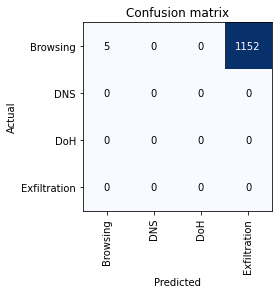

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Obviously the model would be really good at this; it was trained on it.

# Test on Python Queries

This data was recorded by doing random queries with the python DoH client used for exfiltration.

In [ ]:
df_test = pd.read_csv(path + 'feature-engineered/' + 'test-FE.csv')

In [ ]:
data_test = (TabularList.from_df(df_test, cat_names=cat_vars, cont_names=cont_vars, procs=procs, processor=learn.data.processor)
                           .split_none()
                           .label_from_df(cols=dep_var))
data_test.valid = data_test.train
data_test=data_test.databunch()
learn.data.valid_dl = data_test.valid_dl

In [ ]:
learn.validate()

[13.615959, tensor(0.0140)]

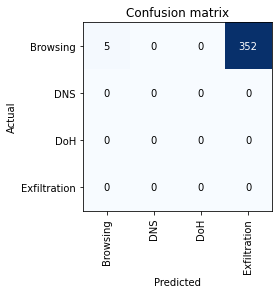

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

There appears to be something about the Python client that creates a different signature compared to the browser's queries.

I don't have an explanation as to what the cause of this is yet, but perhaps this means that there's a lot more to look at.

# Early conjectures

Based on these early results, I can say that without any traffic trickery, DNS over HTTPS traffic can very likely be differentiated from normal browsing. By itself, strange patterns of high frequency DoH traffic can be correlated to exfiltration, but experimenting with this distinction being built into the model is part of the fun.

While it appears to be quite possible to detect DoH traffic, detecting exfiltration is a bit strange; in an ideal script, I don't think low frequency DoH exfiltration can be detected, but in my tests, it definitely notices a pattern.

My working theory for what the model is detecting between the browser and the python script comes down to two things: the TLS version and conversation duration.

My browser appears to be using TLSv1.2 for DoH traffic while the python script uses TLSv1.3 for the traffic.

The conversation with the DoH server from the browser is also longer, more contiguous, and more efficient than the python script which opens a conversation for each query. (The browser offers a lot of keep-alive acknowledgements to the DoH server)

Things I'd like to look into in the future:

*   How different applications use DoH
*   How different DoH servers respond
*   Maintaining open sockets
*   Finding other premade DoH exfiltration tools
